In [1]:
from IPython.core.display import HTML
HTML('<style>.impl-inner{background-color:#e4ffe6} .impl-outer{background-color:#e4ebff} .text_cell_render p { text-align: justify; text-justify: inter-word;}</style>')

# Sliding Mode Control


This discussion on sliding mode control for a multirotor closely follows the work of L'Afflitto et al. [1], in the notation of Khalil [2]. A diagram of the control scheme (taken from [1]) is shown below. In sliding mode control, trajectories of the system are steered to a subspace of the state space (i.e., the sliding manifold) in finite time. Once on this sliding surface, the system can asymptotically converge to the origin without regard to matched uncertainties. In [1], the control architecture shown below is used with sliding mode control to design an autopilot that steers a quadrotor to a given location with a given yaw angle.

![Control Scheme Diagram](assets/smc_control_scheme.png)

## Stabilization

Consider a nonlinear system of the form
\begin{equation}\label{eq:general_nonlinear_sys}
\dot{x} = f(x) + B(x)[G(x)E(x)u + \delta(t,x,u)],\quad x \in \mathbb{R}^n, \ u \in \mathbb{R}^p
\end{equation}
where $f$, $B$, and $E$ are known, while $G$ and $\delta$ could be uncertain. We assume that $E(x)$ is a nonsingular matrix and that $G(x)$ is a diagonal matrix whose elements are positive and bounded away from zero.

Suppose that $f(0) = 0$ so that, in the absence of $\delta$, the origin is an open-loop equilibrium point. **Our goal is to design a state feedback control law to stabilize the origin for all uncertainties in $G$ and $\delta$.**

Given a diffeomorphism $T$, \eqref{eq:general_nonlinear_sys} can be written in *regular form* [1, eq 14.4] as:
\begin{align}
\dot\eta &= f_a(\eta, \xi) \label{eq:normal-eta} \\
\dot\xi  &= f_b(\eta, \xi) + G(x)E(x)u + \delta(t, x, u). \label{eq:normal-xi}
\end{align}

Note that a large class of mechanical systems may be written in regular form, with the kinematics captured by \eqref{eq:normal-eta} and the dynamics captured by \eqref{eq:normal-xi}. This is great because kinematics are typically assumed to be perfectly known, while the dynamics of a system are subject to modeling errors and uncertainties in the system's inertial properties [1].

In keeping with the architecture in the above figure from [1], we will consider the <span class="impl-inner">inner loop</span> and the <span class="impl-outer">outer loop</span> as separate nonlinear systems, writing each in the form of \eqref{eq:general_nonlinear_sys} and creating two sliding mode controllers that work together to stabilize the system around trajectories.

<div class="impl-inner">

For the purposes of control, we consider the inner loop kinematics of a quadrotor to be
\begin{align}
\dot{r_z} &= v_z \\
\dot{\phi} &\approx p \\
\dot{\theta} &\approx q \\
\dot{\psi} &\approx r \\
\end{align}
where we have assumed small angles s.t. $\Gamma \approx I_{3 \times 3}$. The inner loop dynamics are
\begin{align}
\ddot{r_z} &= g - \frac{F}{m}\cos\phi\cos\theta \\
\dot\omega &= -I^{-1} (\omega \times I\omega + M).
\end{align}

In our specific case, we can express the quadrotor system in the form of \eqref{eq:general_nonlinear_sys} with the following definitions:
\begin{align}
x &\triangleq
\begin{bmatrix} x_1 & x_2 & x_3 & x_4 & x_5 & x_6 & x_7 & x_8 \end{bmatrix}^\top =
\begin{bmatrix} r_z & \phi & \theta & \psi & \dot{r}_z & p & q & r \end{bmatrix}^\top \\
u &\triangleq
\begin{bmatrix} u_1 & u_2 & u_3 & u_4 \end{bmatrix}^\top =
\begin{bmatrix} F & \tau_\phi & \tau_\theta & \tau_\psi \end{bmatrix}^\top.
\end{align}

Which evolves as
\begin{align}\label{eq:inner-loop-dynamics-ss}
\dot{x} =
\begin{bmatrix} \dot{x}_1 \\ \dot{x}_2 \\ \dot{x}_3 \\ \dot{x}_4 \\ \dot{x}_5 \\ \dot{x}_6 \\ \dot{x}_7 \\ \dot{x}_8 \end{bmatrix} =
\begin{bmatrix} \dot{r}_z \\ \dot\phi \\ \dot\theta \\ \dot\psi \\ \ddot{r}_z \\ \dot{p} \\ \dot{q} \\ \dot{r} \end{bmatrix} =
\begin{bmatrix}
    x_5 \\ x_6 \\ x_7 \\ x_8 \\
    g - \frac{u_1}{m}\cos x_2 \cos x_3 \\
    \frac{J_y - J_z}{J_x} x_7 x_8 + \frac{1}{J_x} u_2 \\
    \frac{J_z - J_x}{J_y} x_6 x_8 + \frac{1}{J_y} u_3 \\
    \frac{J_x - J_y}{J_z} x_6 x_7 + \frac{1}{J_z} u_4
\end{bmatrix}
\end{align}

In order to transform these inner-loop dynamics into the regular form, we must identify the certain and uncertain components. We can break up \eqref{eq:inner-loop-dynamics-ss} into
\begin{align}
\dot{x} =
\underbrace{\begin{bmatrix}
    x_5 \\ x_6 \\ x_7 \\ x_8 \\
    g \\
    \frac{J_y - J_z}{J_x} x_7 x_8 \\
    \frac{J_z - J_x}{J_y} x_6 x_8 \\
    \frac{J_x - J_y}{J_z} x_6 x_7
\end{bmatrix}}_{f(x)} +
\underbrace{\begin{bmatrix}
    0_{4\times 4} \\ \hdashline
    I_{4\times 4}
\end{bmatrix}}_{B(x)}
\left(
\underbrace{\begin{bmatrix}
\frac{\cos x_2\cos x_3}{m} &0&0&0 \\
0& \frac{1}{J_x} &0&0 \\
0&0& \frac{1}{J_y} &0 \\
0&0&0& \frac{1}{J_z}
\end{bmatrix}}_{G(x)}
\underbrace{\begin{bmatrix}
-1&0&0&0 \\
0&1&0&0 \\
0&0&1&0 \\
0&0&0&1
\end{bmatrix}}_{E(x)}
\underbrace{\begin{bmatrix}
u_1 \\ u_2 \\ u_3 \\ u_4
\end{bmatrix}}_{u} +
\underbrace{0_{4\times 1}}_{\delta(t, x, u)}
\right).
\end{align}

Note how $G(x)$ contains the mass and the inertia terms, which are likely to be uncertain.

We then use the identity diffeomorphism $T:D\to\mathbb{R}^{n=8}, x\mapsto x$ to transform this system into the regular form:
\begin{align}
\eta &=
\begin{bmatrix} x_1 & x_2 & x_3 & x_4 \end{bmatrix}^\top =
\begin{bmatrix} r_z & \phi & \theta & \psi \end{bmatrix}^\top \in \mathbb{R}^{n-p=4} \\
\xi &=
\begin{bmatrix} x_5 & x_6 & x_7 & x_8 \end{bmatrix}^\top =
\begin{bmatrix} \dot{r_z} & p & q & r \end{bmatrix}^\top \in \mathbb{R}^{p=4},
\end{align}

which evolves as

\begin{align}
\dot\eta &=
\begin{bmatrix} \dot{x_1} \\ \dot{x_2} \\ \dot{x_3} \\ \dot{x_4} \end{bmatrix} =
\begin{bmatrix} x_5 \\ x_6 \\ x_7 \\ x_8 \end{bmatrix} = f_a(\eta, \xi) = \xi \\
\dot\xi &=
\begin{bmatrix} \dot{x_5} \\ \dot{x_6} \\ \dot{x_7} \\ \dot{x_8} \end{bmatrix} =
\underbrace{\begin{bmatrix}
    g \\
    \frac{J_y - J_z}{J_x} x_7 x_8 \\
    \frac{J_z - J_x}{J_y} x_6 x_8 \\
    \frac{J_x - J_y}{J_z} x_6 x_7
\end{bmatrix}}_{f_b(\eta,\xi)} +
\underbrace{\begin{bmatrix}
\frac{\cos x_2\cos x_3}{m} & 0_{1\times 3} \\
0_{3\times 1} & I^{-1}
\end{bmatrix}}_{G(x)}
\underbrace{\begin{bmatrix}
-1 & 0_{1\times 3} \\
0_{3\times 1} & I_{3\times 3}
\end{bmatrix}}_{E(x)}
\underbrace{\begin{bmatrix}
u_1 \\ u_2 \\ u_3 \\ u_4
\end{bmatrix}}_{u} +
\underbrace{0_{4\times 1}}_{\delta(t, x, u)}
\end{align}


<div class="impl-outer">

The outer loop kinematics are
$$
\begin{align}
\dot{r}_x &= v_x \\
\dot{r}_y &= v_y
\end{align}
$$
with dynamics
$$
\begin{align}
\ddot{r}_x &= -\frac{u_1}{m}\left( \cos\phi\sin\theta\cos\psi + \sin\phi\sin\psi \right) \\
\ddot{r}_y &= -\frac{u_1}{m}\left( \cos\phi\sin\theta\sin\psi - \sin\phi\cos\psi \right).
\end{align}
$$

Expressing the outer loop in state-space form yields
$$
\begin{align}
x &\triangleq
\begin{bmatrix} x_1 & x_2 & x_3 & x_4 \end{bmatrix}^\top =
\begin{bmatrix} r_x & r_y & \dot{r}_x & \dot{r}_y \end{bmatrix}^\top \\
u &\triangleq
\begin{bmatrix} d_1 & d_2 \end{bmatrix}^\top =
\begin{bmatrix} \theta^d & \phi^d \end{bmatrix}^\top.
\end{align}
$$

Using the small-angle approximation ($\cos\theta\approx 1$; $\sin\theta\approx\theta$), we can write the evolution of the state vector as
$$
\begin{align}\label{eq:outer-loop-dynamics-ss}
\dot{x} =
\begin{bmatrix} \dot{x}_1 \\ \dot{x}_2 \\ \dot{x}_3 \\ \dot{x}_4 \end{bmatrix} =
\begin{bmatrix} \dot{r}_x \\ \dot{r}_y \\ \ddot{r}_x \\ \ddot{r}_y \end{bmatrix} =
\begin{bmatrix}
    x_3 \\ x_4 \\
    -\frac{u_1}{m}\left( \cos\phi\sin\theta\cos\psi + \sin\phi\sin\psi \right) \\
    -\frac{u_1}{m}\left( \cos\phi\sin\theta\sin\psi - \sin\phi\cos\psi \right)
\end{bmatrix} \approx
\begin{bmatrix}
    x_3 \\ x_4 \\
    -\frac{u_1}{m}\left( \theta\cos\psi + \phi\sin\psi \right) \\
    -\frac{u_1}{m}\left( \theta\sin\psi - \phi\cos\psi \right)
\end{bmatrix}.
\end{align}
$$

Similar as with the inner loop, we break \eqref{eq:outer-loop-dynamics-ss} into certain and uncertain components so that it is of the form of \eqref{eq:general_nonlinear_sys}.
$$
\begin{align}
\dot{x} =
\underbrace{\begin{bmatrix}
    x_3 \\ x_4 \\ 0 \\ 0
\end{bmatrix}}_{f(x)} +
\underbrace{\begin{bmatrix}
    0_{2\times 2} \\ \hdashline
    I_{2\times 2}
\end{bmatrix}}_{B(x)}
\left(
\underbrace{\left( \frac{1}{m} I_{2\times 2} \right)}_{G(x)}
\underbrace{
\begin{bmatrix}-u_1&0\\0&u_1\end{bmatrix}
\begin{bmatrix}
\cos\psi&\sin\psi \\
-\sin\psi&\cos\psi
\end{bmatrix}
}_{E(x)}
\underbrace{\begin{bmatrix}
\theta^d \\ \phi^d
\end{bmatrix}}_{u} +
\underbrace{0_{4\times 1}}_{\delta(t, x, u)}
\right).
\end{align}
$$

Again using the identity diffeomorphism $T:D\to\mathbb{R}^{n=4}, x\mapsto x$, we transform the system into regular form:
$$
\begin{align}
\eta &=
\begin{bmatrix} x_1 & x_2 \end{bmatrix}^\top =
\begin{bmatrix} r_x & \r_y \end{bmatrix}^\top \in \mathbb{R}^{n-p=2} \\
\xi &=
\begin{bmatrix} x_3 & x_4 \end{bmatrix}^\top =
\begin{bmatrix} \dot{r}_x & \dot{r}_y \end{bmatrix}^\top \in \mathbb{R}^{p=2},
\end{align}
$$
which evolves as
$$
\begin{align}
\dot\eta &=
\begin{bmatrix} \dot{x}_1 \\ \dot{x}_2 \end{bmatrix} =
\begin{bmatrix} x_3 \\ x_4 \end{bmatrix} = f_a(\eta, \xi) = \xi \\
\dot\xi &=
\begin{bmatrix} \dot{x}_3 \\ \dot{x}_4 \end{bmatrix} =
\underbrace{\begin{bmatrix} 0 \\ 0 \end{bmatrix}}_{f_b(\eta,\xi)} +
\underbrace{\left( \frac{1}{m} I_{2\times 2} \right)}_{G(x)}
\underbrace{
\begin{bmatrix}-u_1&0\\0&u_1\end{bmatrix}
\begin{bmatrix}
\cos\psi&\sin\psi \\
-\sin\psi&\cos\psi
\end{bmatrix}
}_{E(x)}
\underbrace{\begin{bmatrix}
\theta^d \\ \phi^d
\end{bmatrix}}_{u} +
\underbrace{0_{4\times 1}}_{\delta(t, x, u)}
\end{align}
$$

Given a system modelled in regular form, the sliding mode controller can be designed. 

> We start by selecting the sliding manifold to be $s = \xi - \phi(\eta) = 0$ so that when motion is restricted to the manifold, the reduced-order model $\dot\eta = f_a(\eta, \phi(\eta))$ has an asymptotically stable origin. The design of $\phi(\eta)$ amounts to solving a stabilization problem for the system $\dot\eta = f_a(\eta,\xi)$ with $\xi$ viewed as the control input. This stabilization problem may be solved using any other technique, such as backstepping, feedback linearzation, etc. Upon designing a stabilizing controller $\phi(\eta)$, we must design an input $u$ that steers trajectories of $\dot\xi$ to the manifold $s=0$ (i.e., steers $\xi$ to $\phi(\eta)$) in finite time and maintains it there for all future time.

<p style="text-align: right">Khalil, p. 564 [2]</p>

We can achieve this by inspecting the time-evolution of the manifold $s$, which is
\begin{equation}
\dot{s} = f_b(\eta,\xi) - \frac{\partial\phi}{\partial\eta} f_a(\eta,\xi) + G(x)E(x)u + \delta(t,x,u)
\end{equation}

The control is given by
$$
\begin{equation}
u = E^{-1}(x)\left\{ -L(x)\left[ f_b(\eta,\xi) - \frac{\partial\phi}{\partial\eta} f_a(\eta,\xi) \right] + v \right\}
\end{equation}
$$
where
\begin{equation}
v = -\beta(x) \text{sgn}(s)
\end{equation}

<div class="impl-inner">

The inner loop control strategy is defined as follows:

\begin{equation}
\phi(\eta) = -K\eta
\end{equation}

In [2]:
%%capture
# Load the quadrotor simulator from a previous notebook
%run quadsim.ipynb

In [16]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

def sat(v):
    v = np.copy(v)
    v[np.abs(v) > 1] = np.sign(v[np.abs(v) > 1])
    return v

class SMC(Controller):
    """Sliding Mode Controller
    """
    def __init__(self):
        self.name = "SMC"
        
        # Value of total thrust from last iteration
        self.u1_d1 = 0
        
        # estimates of the physical properties of the quadrotor
        self.g = 9.8
        self.mass = 4
        Jxx = 0.1; Jyy = 0.1; Jzz = 0.1
        self.I = np.array([[Jxx,0,0],
                           [0,Jyy,0],
                           [0,0,Jzz]])
        
        # proportional control law \phi(\eta) that stabilizes the inner \dot\eta = f_a system
        self.inner_Keta = np.diag(np.array([3,1,4,1]))
        
        # proportional control law \phi(\eta) that stabilizes the outer \dot\eta = f_a system
        self.outer_Keta = np.diag(np.array([1,1]))
               
    def inner(self, desired, state):
        
        def fa(eta, xi):
            return xi

        def fb(eta, xi):
            # extract omega from xi
            omega = xi[1:4]

            r = np.zeros((4,1))
            r[0,0] = self.g
            r[1:4] = -np.linalg.inv(self.I).dot(np.cross(omega, self.I.dot(omega), axis=0))
            return r
        
        # Transform the system into the form of HK (14.4) and (14.5)
        eta = np.array([state.flatten()[[2, 6, 7, 8]]]).T # r_z, ph, th, ps
        xi = np.array([state.flatten()[[5, 9, 10, 11]]]).T # \dot{r_z}, p, q, r
        
        ph = eta.flatten()[1]
        th = eta.flatten()[2]
        ps = eta.flatten()[3]
        
        # Build the inv(E(x)) matrix
        Einv = np.diag(np.array([-1,1,1,1]))
        
        # Build the L(x) = inv(G(x)) matrix
        L = np.eye(4)
        L[0, 0] = self.mass/(np.cos(ph)*np.cos(th))
        L[1:4, 1:4] = self.I
        
        # equation (18) of [1].
        ueq = -Einv.dot(L.dot(fb(eta, xi) + self.inner_Keta.dot(fa(eta, xi))))
        
        # Build the matrix of sliding surfaces
        SS = xi + self.inner_Keta.dot(eta)
        
        # Gains
        Beta = np.diag(np.array([6,2,7,2]))
        
        # switching components of the control: equation (20) of [1]
        # (but with a boundary on the sliding surface to mitigate chattering)
        gamma = -Beta.dot(sat(SS/1))
        
        # equation (23) of [1]
        u = ueq + Einv.dot(gamma)
        
        return u
    
    def outer(self, u1, state):
        
        # Make sure the thrust is non-zero
        if u1 == 0:
            return np.array([0,0])
        
        def fa(eta, xi):
            return xi

        def fb(eta, xi):
            return np.zeros((2,1))
        
        # Transform the system into the form of HK (14.4) and (14.5)
        eta = np.array([state.flatten()[[0, 1]]]).T # r_x, r_y
        xi = np.array([state.flatten()[[3, 4]]]).T # \dot{r}_x, \dot{r}_y
        
        ps = state.flatten()[8]
        
        # Build the inv(E(x)) matrix
        R = np.array([
            [ np.cos(ps), np.sin(ps)],
            [-np.sin(ps), np.cos(ps)],
        ])
        Einv = R.T.dot(np.diag(np.array([-1.0/u1,1.0/u1])))
        
        # Build the L(x) = inv(G(x)) matrix
        L = self.mass*np.eye(2)
        
        # equation (18) of [1].
        ueq = -Einv.dot(L.dot(fb(eta, xi) + self.outer_Keta.dot(fa(eta, xi))))
        
        # Build the matrix of sliding surfaces
        SS = xi + self.outer_Keta.dot(eta)
        
        # Gains
        Beta = np.diag(np.array([1,1]))
        
        # switching components of the control: equation (20) of [1]
        # (but with a boundary on the sliding surface to mitigate chattering)
        gamma = -Beta.dot(sat(SS/1))
        
        # equation (23) of [1]
        u = ueq + Einv.dot(gamma)
        
        return u
    
    def update(self, commanded, state, Ts):
        
        #
        # Outer Loop
        #
        
        ref = self.outer(self.u1_d1, state)
        
        #
        # Inner Loop
        #
        
        # build reference signal for inner loop
        ph_ref = ref.flatten()[1]
        th_ref = ref.flatten()[0]
        ps_ref = commanded.flatten()[8]
        rz_ref = commanded.flatten()[2]
        desired = np.array([ph_ref, th_ref, ps_ref, rz_ref])
        
        u = self.inner(desired, state)

        # Save total thrust for the outer loop
        self.u1_d1 = u.flatten()[0]
        
        # update the commanded states
        commanded[6] = ph_ref
        commanded[7] = th_ref
        
        # actuator commands
        return u, commanded

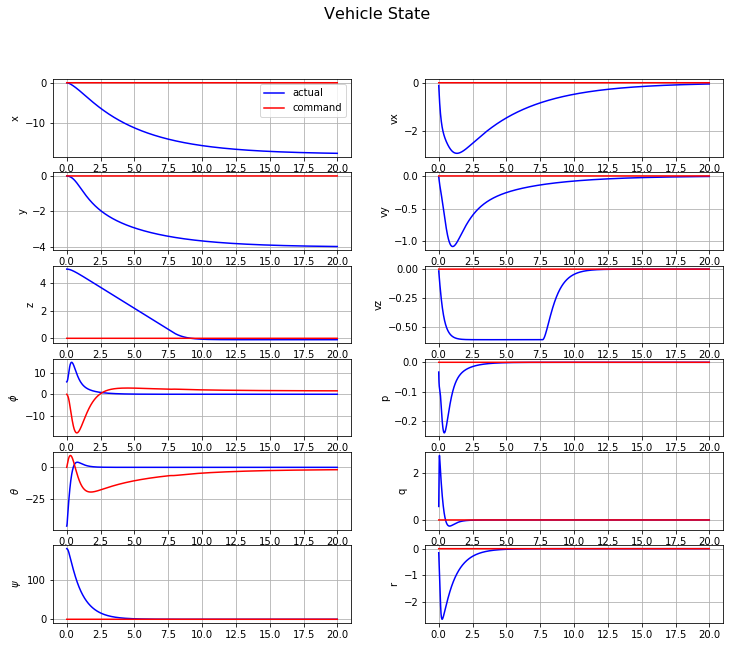

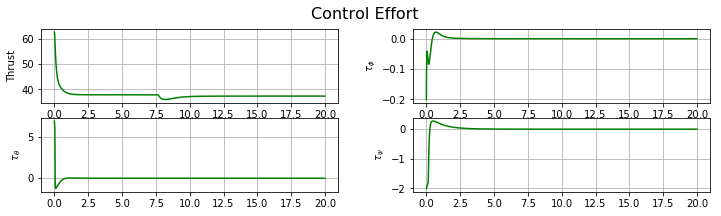

Quadrotor state after 2000 iters:
	r:     [[-17.594 -3.981 -0.101]].T
	Phi:   [[ 0.000  0.000  0.000]].T
	v:     [[-0.052 -0.008 -0.000]].T
	omega: [[-0.000 -0.000 -0.000]].T



In [17]:
quad = Quadrotor(r=np.array([[0],[0],[5]]),
                 v=np.array([[0],[0],[0]]),
               Phi=np.array([[0.1],[-0.8],[3.15]]))
sim = Simulator(quad=quad, ctrl=SMC())
sim.run(20, Ts=0.01)
sim.plot()

print(sim.quad)

## References

[1] A. L’Afflitto, R. Anderson, and K. Mohammadi, “An Introduction to Nonlinear Robust Control for Unmanned Quadrotor Aircraft,” IEEE Control Syst. Mag., vol. 38, no. June, pp. 102–121, 2018.

[2] H. K. Khalil, Nonlinear Systems. Princeton, NJ: Prentice Hall, 2002.

[3] M. K. Shaik and J. F. Whidborne, “Robust Sliding Mode Control of a Quadrotor,” 11th Int. Conf. Control, pp. 1–5, 2016.